# FMCW Intro - Target speed

You can open this workbook in Google Colab to experiment with mmWrt 
[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/Speed.ipynb)

Below is an intro to mmWrt for simple targets position and speed estimation based on 2D FFT Range Doppler


## The problem

As distance changes over time, how can FMCW radar measure speed ?

## The solution

A 2D FFT will allow to measure the speed of the targets

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt
print(datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
2024-05-12 18:32:02.900701


In [2]:
from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import where, expand_dims
from numpy import complex_ as complex

# uncomment below if the notebook is launched from project's root folder
# dp = abspath(join(".",pardir))
# sys.path.insert(0, dp)


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402

## Step by step

Looking at multiple 1D FFT before doing a 2D FFT

32
(32, 64)


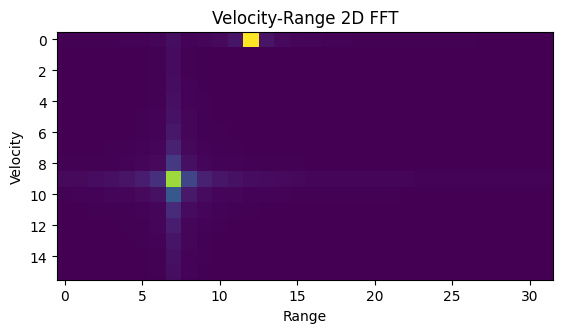

In [3]:
from scipy.fft import fft, fft2
c = 3e8

debug_ON = False
test = 0
NC=32
NA=64
fs0 = 1e5
slope0 = 28e10
tic0 = 1.2e-3
radar = Radar(transmitter=Transmitter(bw=0.2e9, slope=slope0,
                                      t_inter_chirp=tic0,
                                      chirps_count=NC),
              receiver=Receiver(fs=fs0, n_adc=NA, max_adc_buffer_size=256,
                                debug=debug_ON), debug=debug_ON)

target1 = Target(5)
target2 = Target(xt=lambda t: 0.6*t+3)

targets = [target1, target2]

bb = rt_points(radar, targets, datatype=complex, debug=debug_ON)
print(bb["chirps_count"])
cube = bb["adc_cube"][0,:,0,0,:]
print(cube.shape)
Z_fft2 = abs(fft2(cube))
Data_fft2 = Z_fft2

plt.xlabel("Range")
plt.ylabel("Velocity")
plt.title('Velocity-Range 2D FFT')
plt.imshow(Data_fft2[0:NC//2,:NA//2])


## Plotting the Range Doppler with units

> leveraging the plot_range_doppler utility function

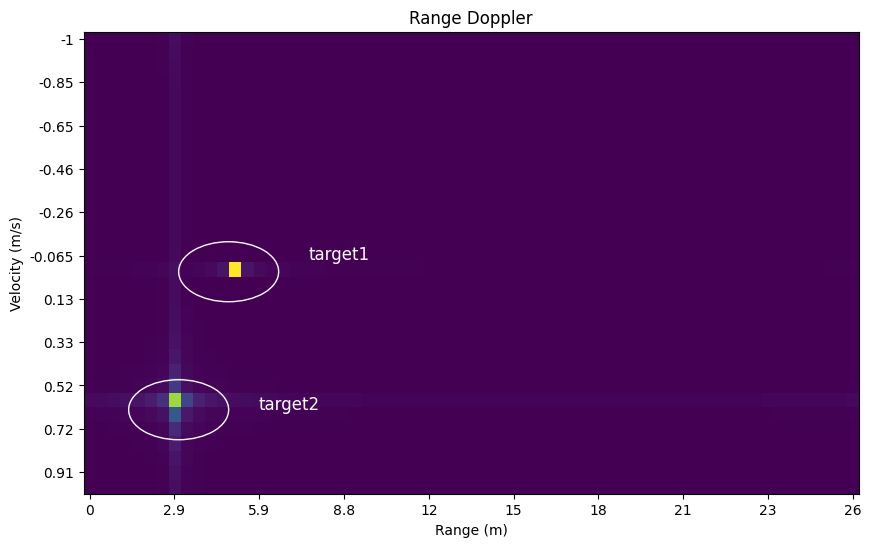

In [6]:
from mmWrt.Plots import plot_range_doppler
fig, _, _ = plot_range_doppler(bb["adc_cube"][0,:,0,0,:], radar, no_speed_shift=False)

# add comments in picture
fig.text(0.35, 0.5, "target1", color="white", fontsize=12)
target1 = plt.Circle((0.27, 0.48), 0.05, fill=False, color="white")
fig.text(0.30, 0.25, "target2", color="white", fontsize=12)
target2 = plt.Circle((0.22, 0.25), 0.05, fill=False, color="white")
fig.add_artist(target1)
fig.add_artist(target2)

## Illustration of 1D FFT and 2D FFT

### Plot all the range FFT

> Scroll output of next cell to see all the range FFTs

C:\Users\matth\AppData\Local\Temp\ipykernel_20768\2651558762.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(name='CMRmap_r')


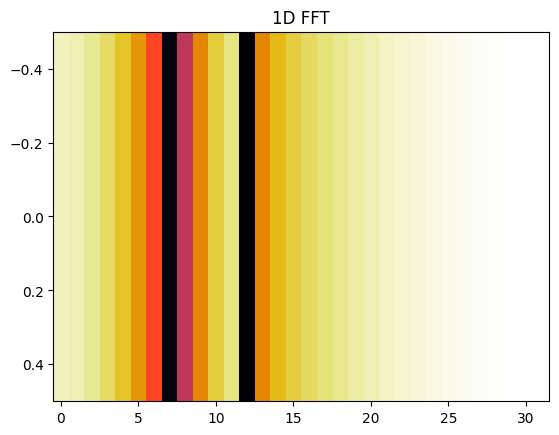

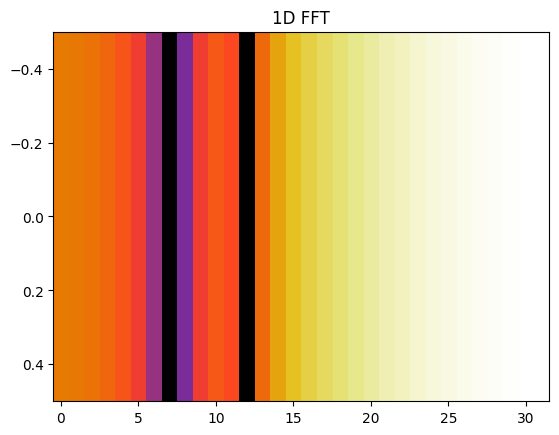

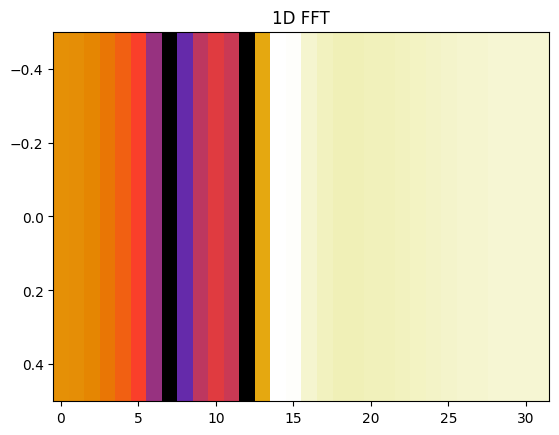

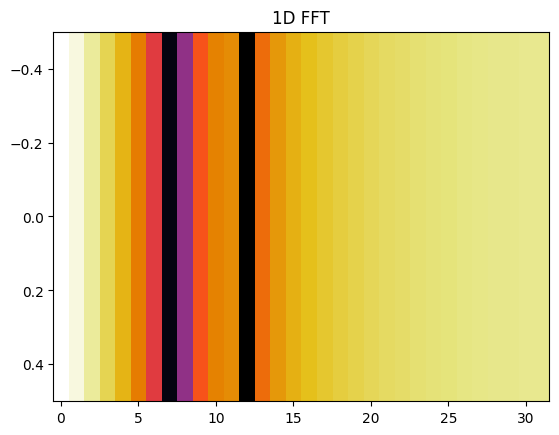

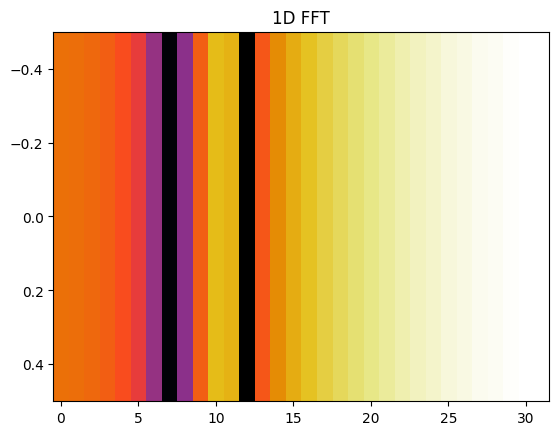

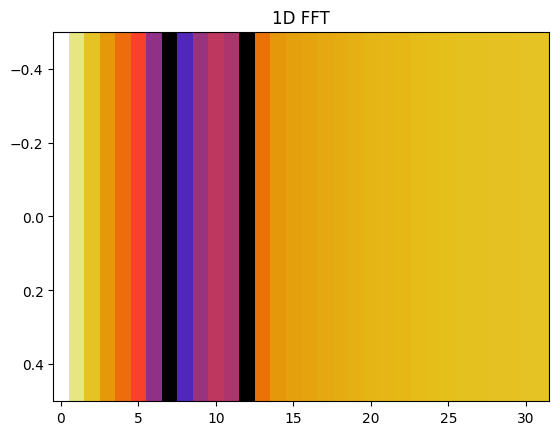

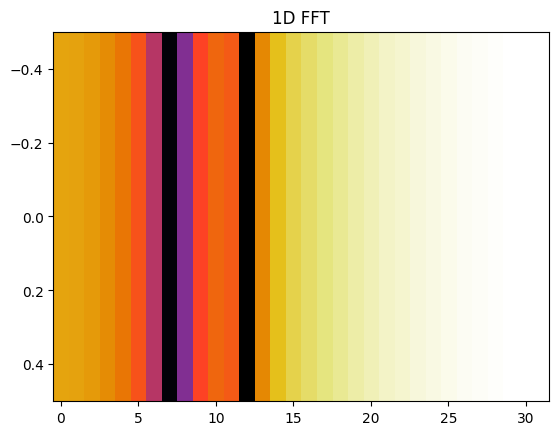

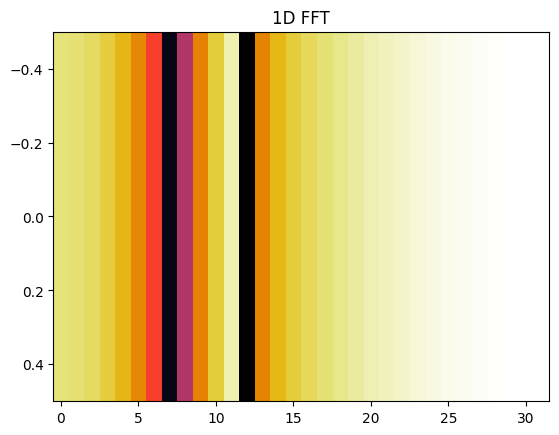

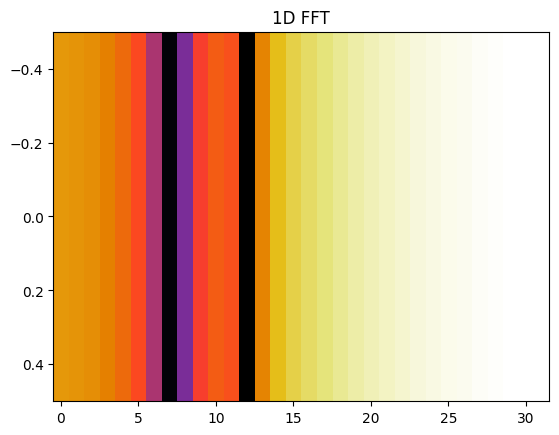

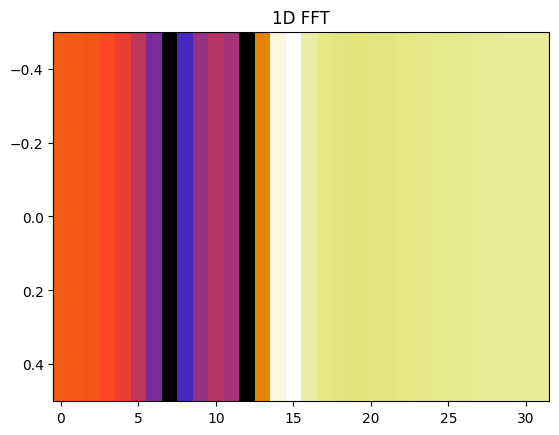

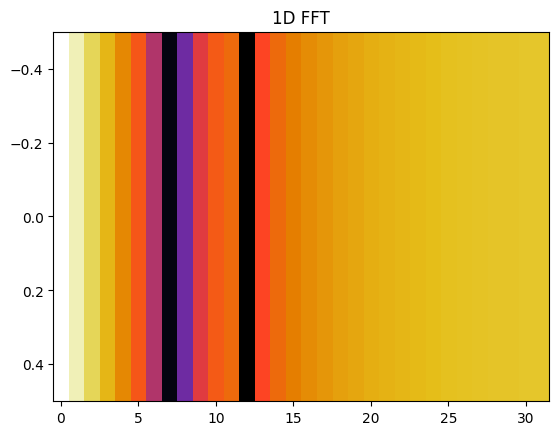

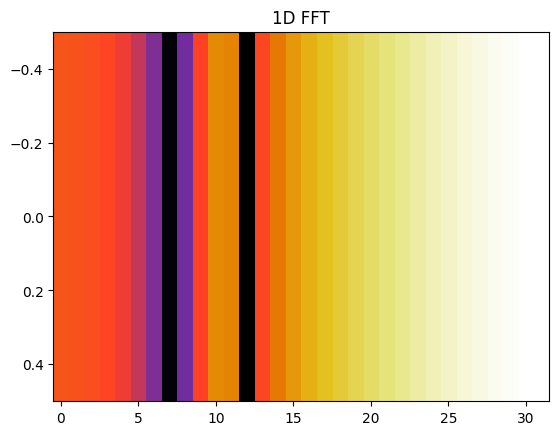

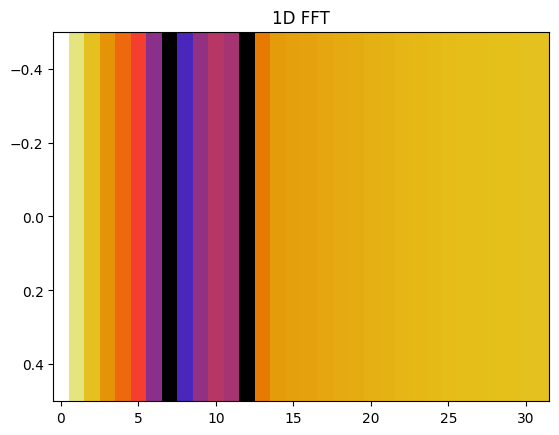

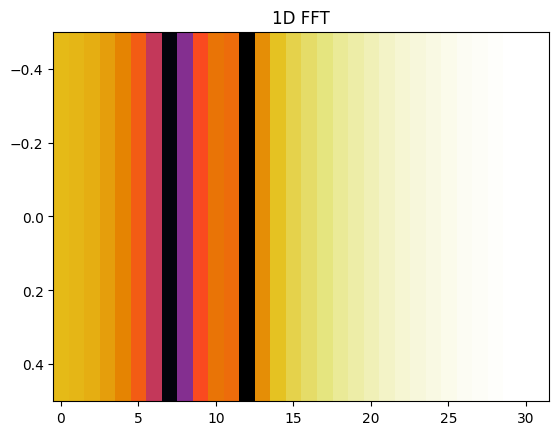

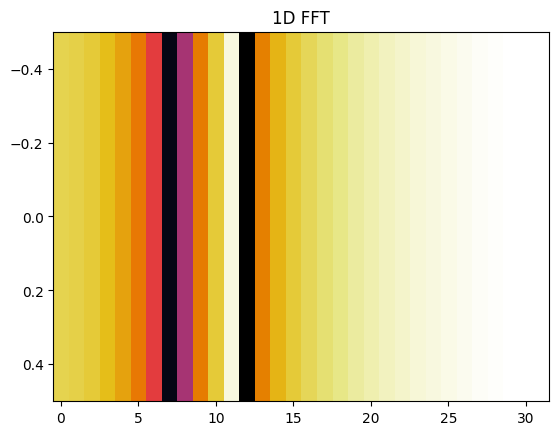

In [7]:
bb = rt_points(radar, targets, debug=debug_ON)
cmap = cm.get_cmap(name='CMRmap_r')
ffts = []
for chirp_i in range(15):
    adc = bb["adc_cube"][0,chirp_i,0,0,:]
    range_profile = fft(adc)

    mag_r = abs(range_profile[:len(range_profile)//2])
    mag_r = expand_dims(mag_r, axis=0)
    plt.imshow(mag_r, cmap,
           aspect='auto',
           norm=colors.LogNorm(vmin=min(mag_r[0][:]), vmax=max(mag_r[0][:])))
    plt.title("1D FFT")
    # plt.savefig(fp_fft_1D)
    plt.show()
    ffts.append(range_profile[:21])

### Range FFT on cube

> 1D FFT on 2D cube, shows 2 targets

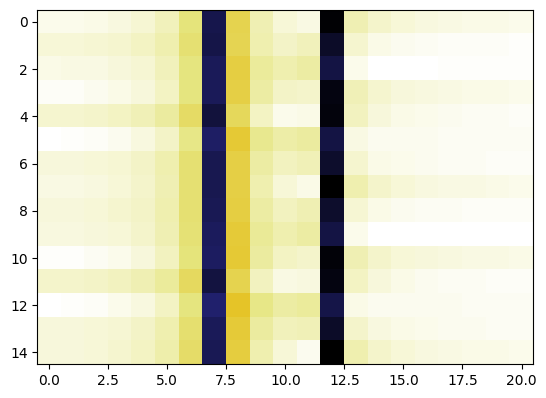

In [8]:
from numpy import array
ffts = array(ffts)
plt.imshow(abs(ffts), cmap=cmap)

### Range Doppler FFT on cube

> 2nd FFT on 2D cube shows one static target and one moving

> similarly as to a 2D FFT would.

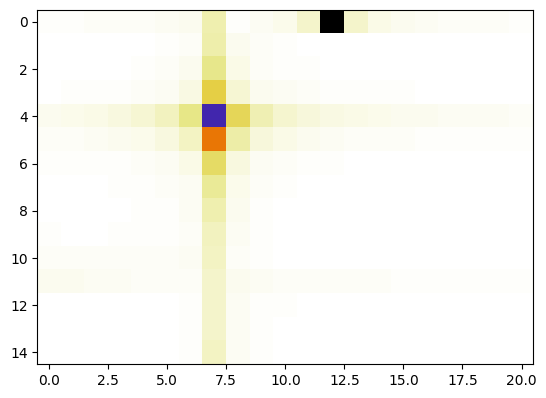

In [9]:
fft2 = fft(ffts, axis=0)
plt.imshow(abs(fft2), cmap=cmap)